# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [3]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

100.0%


Посмотрим на изображения:

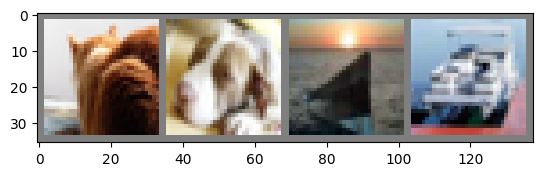

cat dog ship ship car plane plane car


In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(8)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [48]:
n_classes = 10


class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Первый сверточный слой
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Второй сверточный слой
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, padding=1
        )
        self.bn2 = nn.BatchNorm2d(32)

        # Третий сверточный слой (обходной путь)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # Average pooling для уменьшения размерности до 4x4
        self.avgpool = nn.AvgPool2d(kernel_size=8)

        # Полносвязный слой для классификации
        self.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        # == Основной путь ==
        identity = x

        # Первый блок
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        # Второй блок
        out = self.conv2(out)
        out = self.bn2(out)

        # == Обходной путь ==
        identity = self.conv3(identity)

        # Сложение основного и обходного путей
        out += identity
        out = F.relu(out)

        # Уменьшение размерности и классификация
        out = self.avgpool(out)
        out = torch.flatten(out, 1)  # Преобразование в вектор размерности 512
        out = self.fc(out)

        return out

In [49]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [50]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

> Note: Делаю на Mac, поэтому "mps"

In [23]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [25]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [51]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():  # Отключаем подсчет градиентов для экономии памяти
        for data, target in loader:
            # Переносим данные на нужное устройство
            data, target = data.to(device), target.to(device)

            # Получаем предсказания модели
            output = model(data)

            # Считаем функцию потерь
            loss = F.cross_entropy(output, target)
            loss_log.append(loss.item())

            # Считаем accuracy
            pred = output.argmax(dim=1)
            acc = pred.eq(target).float().mean()
            acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        # Переносим данные на нужное устройство
        data, target = data.to(device), target.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Получаем предсказания модели
        output = model(data)

        # Считаем функцию потерь
        loss = F.cross_entropy(output, target)

        # Делаем шаг градиентного спуска
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        # Считаем accuracy
        with torch.no_grad():
            pred = output.argmax(dim=1)
            acc = pred.eq(target).float().mean()
            acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            # Проверяем тип - нужно для задяния с перебором типов шедулеров
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)  # Передаем значение метрики
            else:
                scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [27]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.5412014193247179, train acc: 0.45064393443206985
 val loss: 1.3608882409461, val acc: 0.5177748227373082

Epoch 1
 train loss: 1.2420473000685084, train acc: 0.5624387895167419
 val loss: 1.1431666493415833, val acc: 0.59904698577333

Epoch 2
 train loss: 1.1025865894131077, train acc: 0.6132639070097663
 val loss: 1.1098940042739218, val acc: 0.6146498226104898

Epoch 3
 train loss: 1.0442908942372533, train acc: 0.6356465461267196
 val loss: 1.0322012269750553, val acc: 0.6357269502700643

Epoch 4
 train loss: 1.0023598431233296, train acc: 0.6488272068269509
 val loss: 1.067711124014347, val acc: 0.6332446808510638

Epoch 5
 train loss: 0.9739688601092839, train acc: 0.6621139657562786
 val loss: 1.0213475810720565, val acc: 0.6459663120990103

Epoch 6
 train loss: 0.9427736970362759, train acc: 0.6736745886654479
 val loss: 0.956712826515766, val acc: 0.6720744680851064

Epoch 7
 train loss: 0.9300526340221357, train acc: 0.6756700509427016
 val loss: 0.93767

Посчитайте точность на тестовой выборке:

In [28]:
# <your code here>
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.6873


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

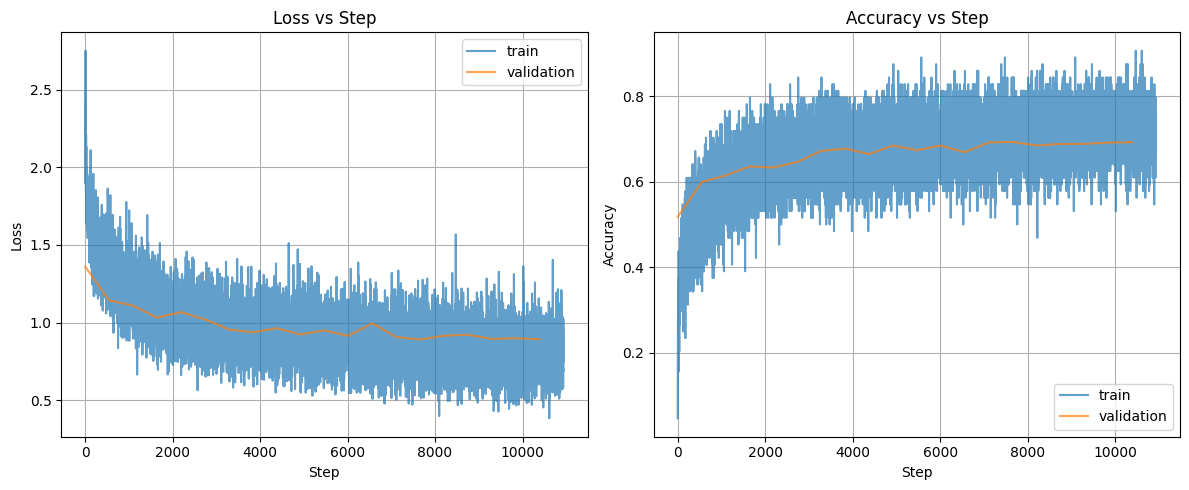

In [29]:
# <your code here>
import matplotlib.pyplot as plt

# Создаем массивы шагов
train_steps = range(len(train_loss_log))
val_steps = range(0, len(train_loss_log), len(train_loss_log) // len(val_loss_log))[
    : len(val_loss_log)
]

# Настраиваем размер графиков
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss_log, label="train", alpha=0.7)
plt.plot(val_steps, val_loss_log, label="validation", alpha=0.7)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss vs Step")
plt.legend()
plt.grid(True)

# График точности
plt.subplot(1, 2, 2)
plt.plot(train_steps, train_acc_log, label="train", alpha=0.7)
plt.plot(val_steps, val_acc_log, label="validation", alpha=0.7)
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Step")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [30]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4777911940701918, train acc: 0.47464253065573014
 val loss: 1.2850274978800023, val acc: 0.5546320922831272

Epoch 1
 train loss: 1.142191104086923, train acc: 0.6004913162705667
 val loss: 1.0705227068130005, val acc: 0.6277039007937655

Epoch 2
 train loss: 1.047090424371158, train acc: 0.6388376533876171
 val loss: 1.05918237325993, val acc: 0.6307845744680851

Epoch 3
 train loss: 0.9881104247225704, train acc: 0.6565805367403535
 val loss: 0.973069635857927, val acc: 0.6646719859001484

Epoch 4
 train loss: 0.9495713388244238, train acc: 0.6695979694125858
 val loss: 1.0134510514583994, val acc: 0.6449689716734784

Epoch 5
 train loss: 0.9229233396772493, train acc: 0.6784204426587609
 val loss: 0.9292132816416152, val acc: 0.6812056738011381

Epoch 6
 train loss: 0.8991585777599154, train acc: 0.6870470422931302
 val loss: 0.9404816827875503, val acc: 0.6775265957446809

Epoch 7
 train loss: 0.8756544578010029, train acc: 0.6947432424076296
 val loss: 0.969

Посчитайте точность на тестовой выборке:

In [31]:
# <your code here>
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.7174


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [33]:
# <your code here>
# Создаем новую модель
net = BasicBlockNet().to(device)

# Инициализируем оптимизатор с маленькой скоростью обучения
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Обучаем модель
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

# Проверяем качество на тестовой выборке
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy with constant lr=0.001: {test_acc:.4f}")

Epoch 0
 train loss: 1.8135576594682237, train acc: 0.36416982242350604
 val loss: 1.5893262680540694, val acc: 0.44858156024141516

Epoch 1
 train loss: 1.5090305896738112, train acc: 0.46976609427270766
 val loss: 1.4353756432837628, val acc: 0.4899822695458189

Epoch 2
 train loss: 1.3959659455681195, train acc: 0.5076227474692099
 val loss: 1.3558501801592238, val acc: 0.524423758907521

Epoch 3
 train loss: 1.3305564152257316, train acc: 0.5321477539360632
 val loss: 1.308592806471155, val acc: 0.538031914893617

Epoch 4
 train loss: 1.275084083651276, train acc: 0.5545099895222749
 val loss: 1.290030168979726, val acc: 0.5512189716734784

Epoch 5
 train loss: 1.227277475475611, train acc: 0.5698983089579525
 val loss: 1.2250408913226838, val acc: 0.5675088652904997

Epoch 6
 train loss: 1.1859566924558915, train acc: 0.5840583377172132
 val loss: 1.1935937731824022, val acc: 0.5830452127659574

Epoch 7
 train loss: 1.1464357325974068, train acc: 0.5984550470407963
 val loss: 1.12

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

1. **ExponentialLR** - экспоненциальное уменьшение скорости обучения
- Умножает learning rate на фиксированный коэффициент gamma после каждой эпохи
- `lr = initial_lr * gamma^epoch`
- Плавное, но постоянное уменьшение скорости обучения
- Хорош, когда мы знаем, что нужно постепенное замедление

In [34]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=0.9
)  # Множитель 0.9 каждую эпоху
print("Training with ExponentialLR scheduler:")
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy with ExponentialLR: {test_acc:.4f}\n")

Training with ExponentialLR scheduler:
Epoch 0
 train loss: 1.539454738335374, train acc: 0.44839954953742855
 val loss: 1.3608211334715499, val acc: 0.5226728723404256

Epoch 1
 train loss: 1.2110934665041824, train acc: 0.5734893249201383
 val loss: 1.1239529335752447, val acc: 0.6082003545253835

Epoch 2
 train loss: 1.0630779894004139, train acc: 0.6297499346776679
 val loss: 1.0540917541118378, val acc: 0.6362145389648194

Epoch 3
 train loss: 0.9884760688166295, train acc: 0.6595472054899938
 val loss: 0.9619793430287787, val acc: 0.6646719859001484

Epoch 4
 train loss: 0.9438082829689849, train acc: 0.672393248874483
 val loss: 1.0115690733524079, val acc: 0.6465203900286491

Epoch 5
 train loss: 0.90910049907904, train acc: 0.6854800535076497
 val loss: 0.9625457844835646, val acc: 0.6677969859001485

Epoch 6
 train loss: 0.8775322026482884, train acc: 0.6947269195612431
 val loss: 0.950785581609036, val acc: 0.6739583332487877

Epoch 7
 train loss: 0.8515528177866334, train a

2. **CosineAnnealingLR** - косинусоидное изменение скорости обучения
- Изменяет learning rate по косинусоидальному закону
- `lr = lr_min + (lr_max - lr_min) * (1 + cos(epoch * pi / T_max)) / 2`
- Позволяет модели периодически "выпрыгивать" из локальных минимумов
- Особенно эффективен при длительном обучении

In [35]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)  # Период 20 эпох
print("Training with CosineAnnealingLR scheduler:")
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy with CosineAnnealingLR: {test_acc:.4f}\n")

Training with CosineAnnealingLR scheduler:
Epoch 0
 train loss: 1.5460711754654182, train acc: 0.45047662571971553
 val loss: 1.2769642558503658, val acc: 0.5490248227373082

Epoch 1
 train loss: 1.2137459895728493, train acc: 0.5736892792162991
 val loss: 1.1167574849534543, val acc: 0.6054078013338942

Epoch 2
 train loss: 1.0724469364452187, train acc: 0.6262772591066099
 val loss: 1.0697903280562542, val acc: 0.6340203901554676

Epoch 3
 train loss: 1.0035424181268682, train acc: 0.651753068733041
 val loss: 1.0237083069821622, val acc: 0.6480718085106383

Epoch 4
 train loss: 0.9592735251953223, train acc: 0.6682309349232661
 val loss: 1.0295518563148822, val acc: 0.6386081561129144

Epoch 5
 train loss: 0.9344422094782702, train acc: 0.6771595063985375
 val loss: 0.9363142520823378, val acc: 0.676529255319149

Epoch 6
 train loss: 0.9025149621083052, train acc: 0.6867287477148081
 val loss: 0.9345551247292376, val acc: 0.6756870566530431

Epoch 7
 train loss: 0.876232322543805, t

3. **ReduceLROnPlateau** - уменьшение скорости обучения при отсутствии улучшения
- Уменьшает learning rate, когда метрика перестает улучшаться
- Если в течение patience эпох нет улучшения, lr умножается на factor
- Адаптивно подстраивается под процесс обучения
- Хорош, когда мы не знаем оптимальное расписание заранее

In [38]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3
)
print("Training with ReduceLROnPlateau scheduler:")
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy with ReduceLROnPlateau: {test_acc:.4f}\n")

Training with ReduceLROnPlateau scheduler:


Epoch 0
 train loss: 1.489127605881072, train acc: 0.46603633455210236
 val loss: 1.2403352940336188, val acc: 0.5605718085106383

Epoch 1
 train loss: 1.1846829833670551, train acc: 0.5851029968348892
 val loss: 1.113541638597529, val acc: 0.6053191489361702

Epoch 2
 train loss: 1.0656430595971549, train acc: 0.6296846435100548
 val loss: 1.0527805569324087, val acc: 0.6386303191489362

Epoch 3
 train loss: 1.0100393800892384, train acc: 0.6519693457666219
 val loss: 1.0455240457615953, val acc: 0.6351728723404255

Epoch 4
 train loss: 0.9709774722128943, train acc: 0.6627995233431159
 val loss: 0.9986731288280893, val acc: 0.6554078014607125

Epoch 5
 train loss: 0.9372550301403625, train acc: 0.6743111778220922
 val loss: 0.9729741776243169, val acc: 0.6640070922831272

Epoch 6
 train loss: 0.9081279989570324, train acc: 0.6848434643510055
 val loss: 0.9309284121432203, val acc: 0.680873226865809

Epoch 7
 train loss: 0.8938423026850281, train acc: 0.689874967338834
 val loss: 0.93

Your answers here:

| Scheduler            | Test Acc | Особенности                           |
|----------------------|----------|---------------------------------------|
| Константа 0.01       | 0.6873   | Бейзлайн                              |
| Константа 0.001      | 0.6478   | Обучалось дольше, результат - хуже    |
| MultiStepLR          | 0.7174   | Ступенчатое изменение в эпохи [10, 15] |
| ExponentialLR        | 0.7159   | Плавное уменьшение learning rate       |
| CosineAnnealingLR    | 0.7203   | Периодическое "выпрыгивание" из локальных минимумов |
| ReduceLROnPlateau    | 0.7245   | Адаптивное уменьшение при плато       |

Опробовали несколько вариантов шедулеров LR. Очевидно, что ReduceLROnPlateau среди них является лучшим выбором, т.к. при сохранении скорости обучения, показывает лучшую точность на тестовых данных.


## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

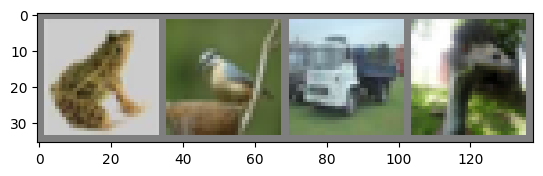

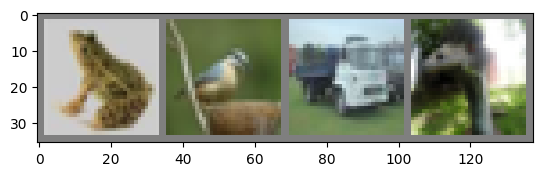

In [40]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [41]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.474451385315855, train acc: 0.47185949335586436
 val loss: 1.2120962361071972, val acc: 0.5809840425531915

Epoch 1
 train loss: 1.1720157766908788, train acc: 0.5880778270622058
 val loss: 1.105155943302398, val acc: 0.6172872340425531

Epoch 2
 train loss: 1.0633479582326286, train acc: 0.6303293941443755
 val loss: 1.1357376859543171, val acc: 0.6048758865670955

Epoch 3
 train loss: 1.0174067090154784, train acc: 0.6460319273650538
 val loss: 1.0500890513683887, val acc: 0.6335328013338941

Epoch 4
 train loss: 0.9742590131227887, train acc: 0.6590085531937356
 val loss: 0.9948344535015999, val acc: 0.6537898936170212

Epoch 5
 train loss: 0.9441995381001362, train acc: 0.6733807783022223
 val loss: 0.9762356501944521, val acc: 0.6605274823117764

Epoch 6
 train loss: 0.9264209086324005, train acc: 0.6782000848318585
 val loss: 0.9161308960711703, val acc: 0.6785682624958931

Epoch 7
 train loss: 0.903950100625019, train acc: 0.6878386981090636
 val loss: 0.9

Посчитайте точность на тестовой выборке:

In [42]:
# <your code here>
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy with RandomHorizontalFlip: {test_acc:.4f}\n")

Test accuracy with RandomHorizontalFlip: 0.7244



**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Попробуем:
- RandomRotation
- RandomCrop
- ColorJitter
- Комбинация всех трех сразу

In [43]:
# RandomRotation
transform_rotation = transforms.Compose(
    [
        transforms.RandomRotation(15),  # Поворот на угол ±15 градусов
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

print("Training with RandomRotation augmentation:")
train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_rotation
)
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy with RandomRotation: {test_acc:.4f}\n")


# RandomCrop
transform_crop = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),  # Случайная обрезка 32x32 с отступом 4
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

print("Training with RandomCrop augmentation:")
train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_crop
)
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy with RandomCrop: {test_acc:.4f}\n")


# ColorJitter
transform_color = transforms.Compose(
    [
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2
        ),  # Изменение цветовых характеристик
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

print("Training with ColorJitter augmentation:")
train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_color
)
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy with ColorJitter: {test_acc:.4f}\n")


# Комбинация всех трех сразу
transform_combined = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

print("Training with combined augmentations:")
train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_combined
)
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
test_loss, test_acc = test(net, test_loader)
print(f"Test accuracy with combined augmentations: {test_acc:.4f}\n")

Training with RandomRotation augmentation:
Epoch 0
 train loss: 1.5810502240165278, train acc: 0.43170132541133455
 val loss: 1.3777068959905747, val acc: 0.5109929078436912

Epoch 1
 train loss: 1.333311267483169, train acc: 0.5232191825697583
 val loss: 1.2142045363466791, val acc: 0.5723847517307769

Epoch 2
 train loss: 1.2063057242843307, train acc: 0.5733913880597521
 val loss: 1.1981075015473872, val acc: 0.5674202127659574

Epoch 3
 train loss: 1.1398210429622224, train acc: 0.599585400856827
 val loss: 1.161858995417331, val acc: 0.5874335106382979

Epoch 4
 train loss: 1.091687202344647, train acc: 0.6184708800786592
 val loss: 1.1036845506505764, val acc: 0.6154476949509154

Epoch 5
 train loss: 1.0682221527945188, train acc: 0.6246164142540648
 val loss: 1.119717023474105, val acc: 0.6103058510638298

Epoch 6
 train loss: 1.033890482821456, train acc: 0.6377481065241031
 val loss: 1.049777127326803, val acc: 0.6323581561129143

Epoch 7
 train loss: 1.0135209550587307, train

Your answers here:

Объяснение аугментаций:
1. RandomRotation(15):
- Случайно поворачивает изображение на угол от -15 до +15 градусов
- Помогает модели стать устойчивой к небольшим поворотам объектов
- Особенно полезно для объектов, которые могут быть по-разному ориентированы
2. RandomCrop(32, padding=4):
- Добавляет отступ 4 пикселя со всех сторон
- Затем случайно вырезает область 32x32
- Помогает модели лучше учитывать различные части объектов
- Делает модель более устойчивой к небольшим сдвигам
3. ColorJitter:
- Случайно изменяет яркость, контраст и насыщенность
- Делает модель устойчивой к различным условиям освещения
- Помогает справляться с разными цветовыми вариациями объектов
4. Комбинация аугментаций:
- Применяет все преобразования последовательно
- Создает более разнообразный набор данных для обучения
- Может привести к лучшей обобщающей способности модели

Результаты применения аугментаций:

| Аугментация     | Test Accuracy |
|-----------------|---------------|
| RandomRotation  | 70.53%        | 
| RandomCrop      | 71.01%        |
| ColorJitter     | 71.27%        | 
| Комбинация всех | 68.70%        |

Все одиночные аугментации улучшили результат по сравнению базовым (~68.7%). Самой эффективной оказалась ColorJitter (71.27%)
Интересно, что комбинация показала наихудший результат. Возможно, стоило увеличить число эпох или ограничиться двумя аугментациями.

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [44]:
# <your code here>
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gkonoff (gkonoff-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Модифицируем функцию обучения, чтобы она логировала в wandb.

Ссылка на отчет в wandb:  
https://api.wandb.ai/links/gkonoff-hse/7nfkzsun

In [46]:
def train_epoch_with_wandb(model, optimizer, train_loader, wandb=wandb):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        # Переносим данные на нужное устройство
        data, target = data.to(device), target.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Получаем предсказания модели
        output = model(data)

        # Считаем функцию потерь
        loss = F.cross_entropy(output, target)

        # Делаем шаг градиентного спуска
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        # Считаем accuracy
        with torch.no_grad():
            pred = output.argmax(dim=1)
            acc = pred.eq(target).float().mean()
            acc_log.append(acc.item())

        # Логируем train метрики
        wandb.log(
            {
                "train/loss": loss.item(),
                "train/accuracy": acc.item(),
                # "train/step": step
            }
        )

    return loss_log, acc_log


def train_with_wandb(
    model, optimizer, n_epochs, train_loader, val_loader, scheduler=None, wandb=wandb
):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch_with_wandb(
            model, optimizer, train_loader, wandb
        )
        val_loss, val_acc = test(model, val_loader)

        # Логируем validation метрики
        wandb.log({"val/loss": val_loss, "val/accuracy": val_acc, "epoch": epoch})

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            # Проверяем тип scheduler'а
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)  # Передаем значение метрики
            else:
                scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [47]:
# Инициализация wandb
wandb.init(
    project="hse-dl-hw2",  # Название проекта
    name="basic-cnn-cifar10",  # Название эксперимента
    config={  # Конфигурация эксперимента
        "architecture": "BasicBlockNet",
        "dataset": "CIFAR10",
        "epochs": 20,
        "batch_size": 64,
        "learning_rate": 0.1,
        "momentum": 0.9,
        "optimizer": "SGD",
    },
)

# Обучаем модель с логированием
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train_with_wandb(
    net, optimizer, 20, train_loader, val_loader, scheduler, wandb
)

# Завершаем эксперимент
wandb.finish()

Epoch 0
 train loss: 1.7279334567364653, train acc: 0.3698215917760755
 val loss: 1.5285596801879557, val acc: 0.45077570917758536

Epoch 1
 train loss: 1.5174540102590808, train acc: 0.45558158135283366
 val loss: 1.483896009972755, val acc: 0.4617242908224146

Epoch 2
 train loss: 1.4098914572918002, train acc: 0.49607844735194384
 val loss: 1.348211869280389, val acc: 0.519747340425532

Epoch 3
 train loss: 1.3384026626782182, train acc: 0.5250473361346578
 val loss: 1.2967387772620993, val acc: 0.5420434396317665

Epoch 4
 train loss: 1.2814125712872424, train acc: 0.5459078741030022
 val loss: 1.2480614053442123, val acc: 0.5626108155605641

Epoch 5
 train loss: 1.2470048997258356, train acc: 0.5573868829981719
 val loss: 1.222536235160016, val acc: 0.5651152481424048

Epoch 6
 train loss: 1.2211321872374694, train acc: 0.5648994515539305
 val loss: 1.1875652168659454, val acc: 0.5833554965384463

Epoch 7
 train loss: 1.2055252568159505, train acc: 0.5746931313814585
 val loss: 1.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 19
 train loss: 1.0157457284997107, train acc: 0.6450811243144424
 val loss: 1.0197495414855633, val acc: 0.6436613476022761



epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/accuracy,▂▁▄▃▄▄▅▃▅▅▅▆▅▇▆▇▅▅▅█▇█▆▅█▇▅▇▅▅▆▅▅▆▇▆▅▇▇▇
train/loss,▅▆▇▆▇█▅▆▅▆▄▄▇▆▅▄▆▅▅▆▄▃▅▅▄▃▆▁▅▅▅▃▆▄▄▂▄▅▄▃
val/accuracy,▁▁▃▄▅▅▆▆▅▆▇█████████
val/loss,█▇▆▅▄▄▃▃▄▃▂▁▁▁▂▁▁▁▁▁
epoch,19
train/accuracy,0.625
train/loss,1.04053
val/accuracy,0.64366
val/loss,1.01975
